# Array processing and curve fitting with Sandia PSL Uncertainty Calculator


To work with arrays in the uncertainty calculator, the uncertarray module is provided.

    >>> from suncal import uncertarray

### 1. Set up an array object with x, y, u(x), and u(y) data
    
First, set up an array object for the calculator to use.

1. If uncertainties in the data points are known, use `uncertarray.Array`.
2. If the data is a collection of measurements at each x value, use `dataset.DataSet` and call `summarize()`.

Note x and y are required 1D arrays. ux and uy are optional. They may be scalars which apply
to the entire x or y, or they may be arrays the same length as x and y.

### 2. Operate on the array

Then, determine what are the desired parameters from the array and use one of the provided
InputFunc classes:

1. To determine x value and uncertainty of a threshold crossing, use `uncertarray.ArrayThresh`
2. To fit any linear or nonlinear function to the array, use `curvefit.CurveFit`
3. To use the array for any other type uncertainty calculations, use `uncertarray.ArrayFunc`


### 3. Going further by using the array in UncertaintyCalc

The results from an `ArrayFunc` or `ArrayThresh` can be used as a function to an `UncertaintyCalc` object. For example, define two `ArrayThresh` objects and subtract them to find the uncertainty of a pulse width.

A line or curve fit results in multiple mean values (e.g. slope and intercept). To use this in an `UncertaintyCalc` object, use `curvefit.CurveFitParam` which wraps the fit class and returns a single parameter for the calculator to use.

In [1]:
import suncal
from suncal import uncertarray
from suncal import curvefit

import scipy
import numpy as np
import matplotlib.pyplot as plt

## Examples

### Linear fit

Find the uncertainty in the slope of a line. Note `a` and `u(a)` are the intercept and uncertainty of the intercept, while `b` and `u(b)` are the slope and uncertainty of slope.

In [2]:
# Make up some line data with scatter
a, b = 10, 0.5
uy = 2.0
x = np.arange(50, 105, step=5)
y = a + b * x + np.random.normal(loc=0, scale=uy, size=len(x))

# Put x, y into Array. Array class can be accessed via uncertarray or curvefit module.
arr = curvefit.Array(x, y, uy=uy)

# Configure line fit calculation
fit = curvefit.CurveFit(arr, func='line')
out = fit.calculate(gum=True, mc=True, lsq=True, mcmc=True)
out

|Method (k=1)              | b         | a        |
|-------------------------|---------|---------|
|Least Squares             | 0.496 ± 0.038 | 9.6 ± 2.9|
|GUM Approximation         | 0.496 ± 0.038 | 9.6 ± 2.9|
|Monte Carlo               | 0.496 ± 0.038 | 9.6 ± 2.9|
|Markov-Chain Monte Carlo  | 0.506 ± 0.037 | 8.9 ± 2.9|

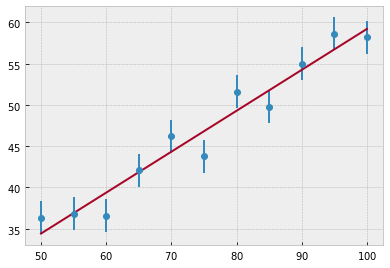

In [3]:
# Use the Calculator's built-in functions to plot the fit line (using least-squares analytical result)
ax = out.lsq.plot_points(ebar=True)
out.lsq.plot_fit(ax=ax);

Note that the uncertainty of the slope and uncertainty of the intercept cannot be directly used to predict the uncertainty of a point on the line (due to correlation between parameters). However, the Calculator output provides a `y` function to predict a point on the line, and functions `u_conf` and `u_pred` to determine a confidence band (confidence that the fit line passes through the true mean) and a prediction band (uncertainty for a new observation at a given x value). Note these are at k=1.

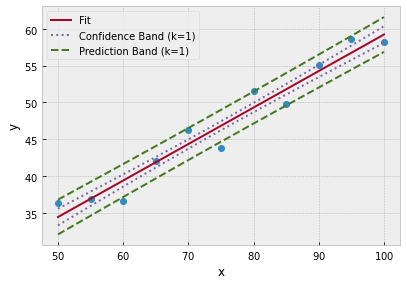

In [4]:
# Use the builtin functions to plot the fit line (using least-squares analytical result)
out.lsq.plot_summary();

### Curve fit

Fitting a non-linear curve is a similar process, but a function to fit must also be specified. In this case, we fit data points to a normal curve to find the center and standard deviation.

|Method (k=1)              | center    | stddev    | offst    |
|-------------------------|---------|---------|---------|
|Least Squares             | 19.971 ± 0.078 | 3.964 ± 0.064 | 7.99958 ± 0.00037|
|GUM Approximation         | 19.971 ± 0.091 | 3.96 ± 0.11 | 7.99958 ± 0.00036|
|Monte Carlo               | 19.973 ± 0.077 | 3.966 ± 0.061 | 7.99959 ± 0.00038|
|Markov-Chain Monte Carlo  | 19.968 ± 0.077 | 3.966 ± 0.065 | 7.99959 ± 0.00037|

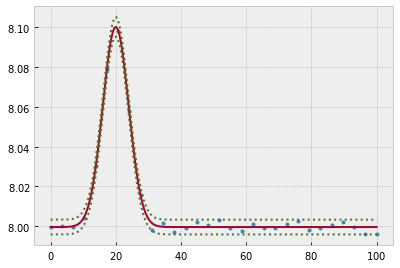

In [5]:
# Make up some fake data
uy = 0.002
x = np.linspace(0,100, num=30)
y = 8 + scipy.stats.norm.pdf(x, loc=20, scale=4) + np.random.normal(loc=0, scale=uy, size=len(x))

# Put data in an Array
arr = curvefit.Array(x, y, uy=uy)

# Define a function to fit the data to. Function takes x values as first parameter, and 
# any other parameters needed to describe the function will be fit. In this case
# we'll fit to a normal function with center a and standard deviation b.
def norm(x, center, stddev, offst):
    return offst + scipy.stats.norm.pdf(x, loc=center, scale=stddev)

# Set up the calculator using ArrayCurveFit. Give it an initial guess p0 to help the solution converge.
n = curvefit.CurveFit(func=norm, arr=arr, p0=(18, 5, 8))

# Run the fit calculation and plot
display(n.calculate(gum=True, mc=True, lsq=True, mcmc=True))
plt.plot(x, y, marker='.', ls='')

xx = np.linspace(0, 100, num=200)
fit = n.out.lsq.y(xx)   # .y() returns fit line y for given x range
plt.plot(xx, fit);

# Prediction/Confidence bands can also be shown as before
u_pred = n.out.lsq.u_pred(xx)  # .u_pred() gives prediction band for given x range
plt.plot(xx, fit+u_pred*2, ls=':', color='C3')  # k=2
plt.plot(xx, fit-u_pred*2, ls=':', color='C3');